<a href="https://colab.research.google.com/github/maximecharriere/TM_PV_ADC/blob/main/00_Scripts/PVLibTestGeneration_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
!pip install pvlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 29.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain

## Modeling paradigms
https://pvlib-python.readthedocs.io/en/stable/user_guide/introtutorial.html#modeling-paradigms

In [ ]:
# %% Modeling paradigms - Setup

# latitude, longitude, name, altitude, timezone
coordinates = [
    (32.2, -111.0, 'Tucson', 700, 'Etc/GMT+7'),
    (35.1, -106.6, 'Albuquerque', 1500, 'Etc/GMT+7'),
    (37.8, -122.4, 'San Francisco', 10, 'Etc/GMT+8'),
    (52.5, 13.4, 'Berlin', 34, 'Etc/GMT-1'),
]

# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

tmys = []
for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

Tucson           435945.540454
Albuquerque      449905.103839
San Francisco    393749.728807
Berlin           243230.970659
dtype: float64


Text(0, 0.5, 'Yearly energy yield (W hr)')

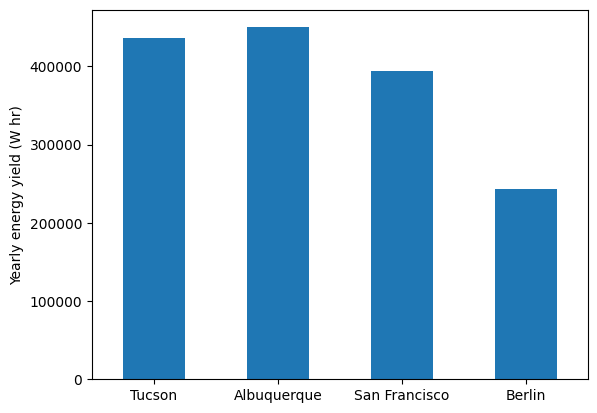

In [ ]:
# %% Modeling paradigms - Object oriented
energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
    )
    mount = FixedMount(surface_tilt=latitude, surface_azimuth=180)
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
    )
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    mc = ModelChain(system, location)
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum()
    energies[name] = annual_energy


energies = pd.Series(energies)

# Output
# based on the parameters specified above, these are in W*hrs
print(energies)
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')

## PVSystem and Arrays
https://pvlib-python.readthedocs.io/en/stable/user_guide/pvsystem.html#pvsystem-and-arrays

In [ ]:
module_parameters = {'pdc0': 5000, 'gamma_pdc': -0.004}
inverter_parameters = {'pdc0': 5000, 'eta_inv_nom': 0.96}

mount = FixedMount(surface_tilt=20, surface_azimuth=180)

array_one = Array(mount=mount, module_parameters=module_parameters)

array_two = Array(mount=mount, module_parameters=module_parameters)

system_two_arrays = PVSystem(arrays=[array_one, array_two],
                                      inverter_parameters=inverter_parameters)


print([array.module_parameters for array in system_two_arrays.arrays])
print(system_two_arrays.inverter_parameters)


[{'pdc0': 5000, 'gamma_pdc': -0.004}, {'pdc0': 5000, 'gamma_pdc': -0.004}]
{'pdc0': 5000, 'eta_inv_nom': 0.96}


In [ ]:
system_two_arrays.arrays[0].module_parameters['pdc0']

5000

## Model Chain

In [110]:
import pandas as pd

import numpy as np


import pvlib

from pvlib.pvsystem import PVSystem, FixedMount

from pvlib.location import Location

from pvlib.modelchain import ModelChain

from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

location = Location(latitude=32.2, longitude=-110.9)

system = PVSystem(surface_tilt=20, surface_azimuth=200,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter,
                  temperature_model_parameters=temperature_model_parameters)


mc = ModelChain(system, location)

print(mc)

weather = pd.DataFrame([[1050, 1000, 100, 30, 5]],
                       columns=['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed'],
                       index=[pd.Timestamp('20170401 1200', tz='US/Arizona')])


mc.run_model(weather)
mc.results.ac


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


2017-04-01 12:00:00-07:00    189.990905
dtype: float64

## Tiergarten_Ost Simulation

### System configuration

In [111]:
location = Location(latitude=47.062365389967134, longitude=7.614255071260409, altitude=533, tz='Europe/Zurich', name='Tiergarten_Ost')


In [112]:
#import the database
modules_database = pvlib.pvsystem.retrieve_sam(name='SandiaMod')
inverters_database = pvlib.pvsystem.retrieve_sam(name='cecinverter')

In [113]:
array1 = Array(
        mount=FixedMount(surface_tilt=30, surface_azimuth=241),
        module_parameters=modules_database['Siemens_Solar_SM55__2002__E__'],
        temperature_model_parameters=pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['close_mount_glass_glass'],
    )

system = PVSystem(arrays=[array1], inverter_parameters=inverters_database['ABB__MICRO_0_25_I_OUTD_US_208__208V_'])

modelChain = ModelChain(system, location)

### Daily clearsky irradiance energy

In [95]:
times_hourly = pd.date_range(start='2023-01-01', end='2023-12-31', freq='1h', tz=location.tz)
cs_hourly_power = location.get_clearsky(times_hourly)  # ineichen with climatology table by default


In [96]:
cs_daily_energy = cs_hourly_power.groupby(cs_hourly_power.index.date).sum()

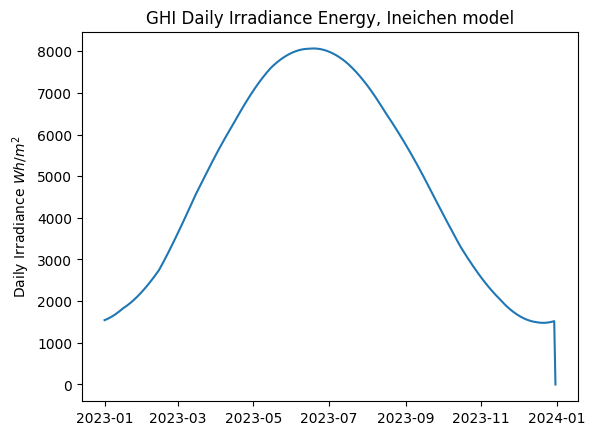

In [97]:
cs_daily_energy['ghi'].plot();
plt.ylabel('Daily Irradiance $Wh/m^2$');
plt.title('GHI Daily Irradiance Energy, Ineichen model');

### Minute clearsky irradiance power

In [98]:
times_minutes = pd.date_range(start='2023-07-01', end='2023-07-03', freq='1min', tz=location.tz)
cs_minutes_power = location.get_clearsky(times_minutes)  # ineichen with climatology table by default

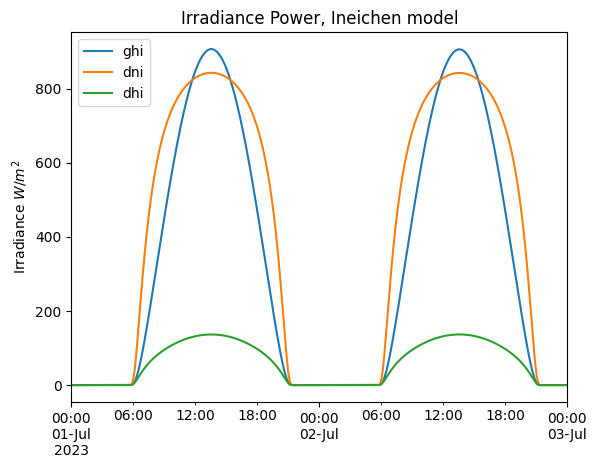

In [101]:
cs_minutes_power.plot();
plt.ylabel('Irradiance $W/m^2$');
plt.title('Irradiance Power, Ineichen model');

### AC Power

In [115]:
modelChain.run_model(cs_minutes_power)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [116]:
modelChain.results.ac.sum()

37440.59931914485

## PVLib pvwatts inverter model

This plot show the efficiency of a default inverter, depending of its reference DC power

In [68]:
# Generate a range of values for Pdc and Pdc0
load = np.linspace(0.00001, 1.2, 100)
Pdc0 = np.ones(load.shape)*1000
Pdc = Pdc0*load
Pac = pvlib.inverter.pvwatts(pdc=Pdc, pdc0=Pdc0)
n = Pac/Pdc


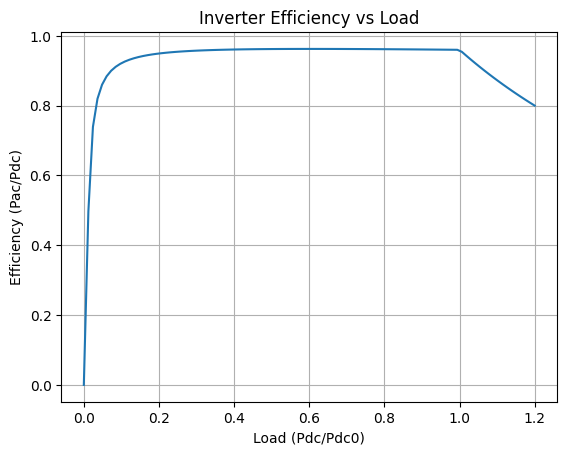

In [72]:
plt.plot(load, n, label='Inverter Efficiency')
plt.title('Inverter Efficiency vs Load')
plt.xlabel('Load (Pdc/Pdc0)')
plt.ylabel('Efficiency (Pac/Pdc)')
plt.grid(True)
plt.show()